In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 设置股票代码
ticker = "TQQQ"

# 下载 5 天的 5分钟级数据
data = yf.download(ticker, interval="5m", period="max")
df = data.reset_index().droplevel(1, axis=1)
print('lastest time')
print(list(df['Datetime'])[-1])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

lastest time
2025-07-03 16:55:00+00:00


[*********************100%***********************]  1 of 1 completed


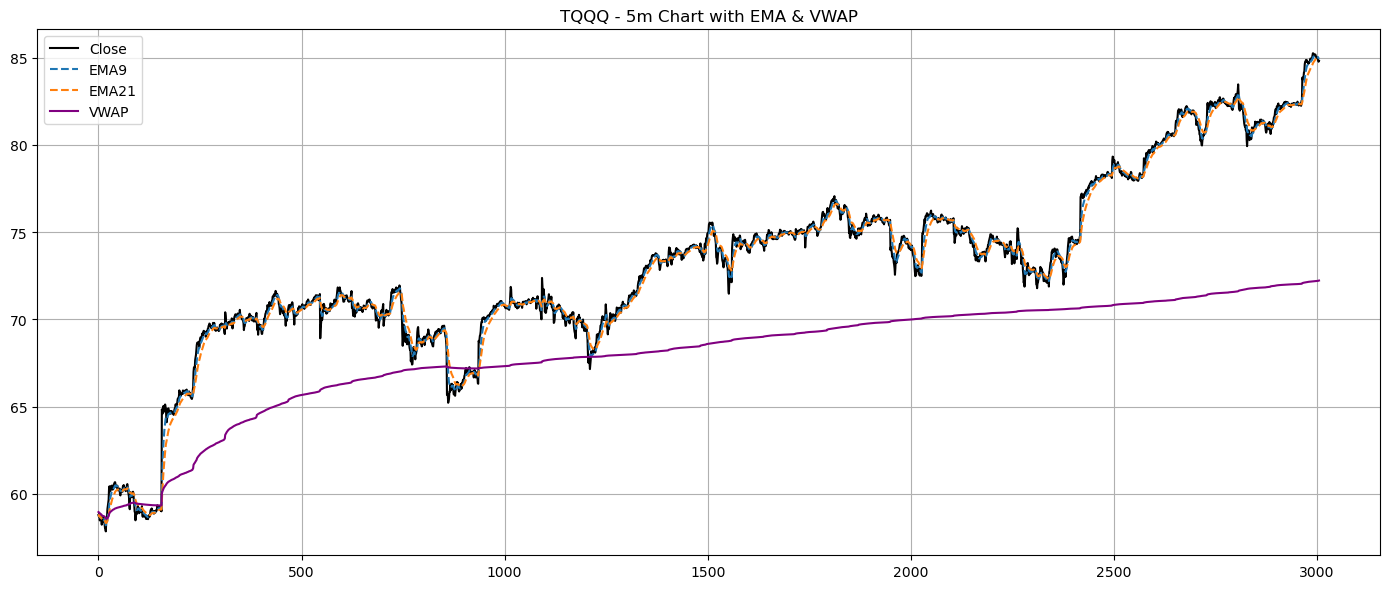

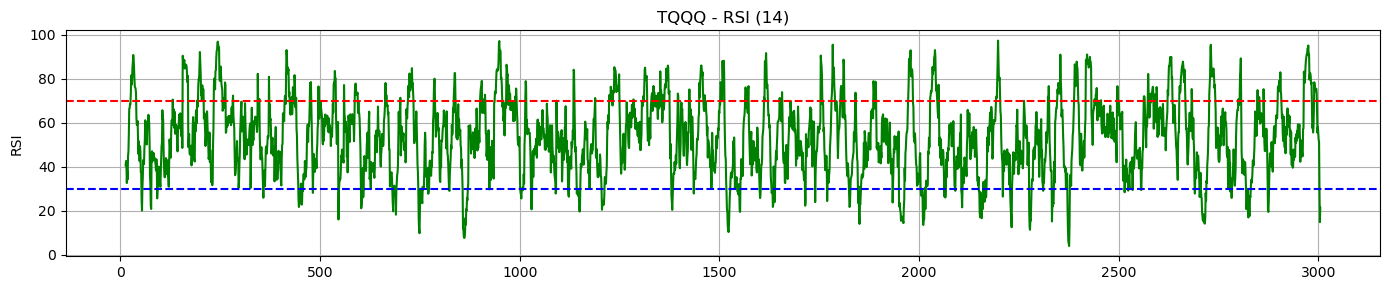

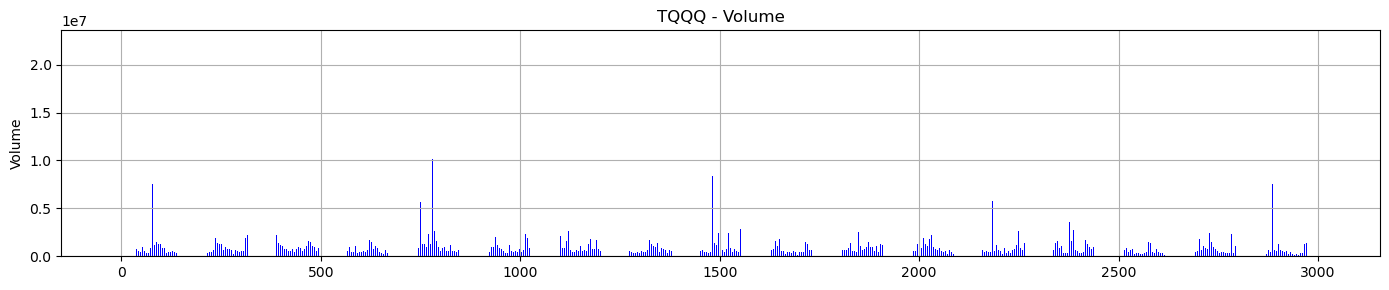

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 设置股票代码
ticker = "TQQQ"

# 下载 5 天的 5分钟级数据
data = yf.download(ticker, interval="5m", period="max")
df = data.reset_index().droplevel(1, axis=1)
# 计算技术指标
df["EMA9"] = df["Close"].ewm(span=9).mean()
df["EMA21"] = df["Close"].ewm(span=21).mean()

# RSI
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# VWAP
df["Typical_Price"] = (df["High"] + df["Low"] + df["Close"]) / 3
df["Cum_TP_Vol"] = (df["Typical_Price"] * df["Volume"]).cumsum()
df["Cum_Volume"] = df["Volume"].cumsum()
df["VWAP"] = df["Cum_TP_Vol"] / df["Cum_Volume"]

# 主图
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"], label="Close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.title(f"{ticker} - 5m Chart with EMA & VWAP")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# RSI 图
plt.figure(figsize=(14, 3))
plt.plot(df.index, df["RSI"], label="RSI", color="green")
plt.axhline(70, color="red", linestyle="--")
plt.axhline(30, color="blue", linestyle="--")
plt.title(f"{ticker} - RSI (14)")
plt.ylabel("RSI")
plt.grid()
plt.tight_layout()
plt.show()

# volumn plot
plt.figure(figsize=(14, 3))
plt.bar(df.index, df["Volume"], width=0.3, color="blue")
plt.title(f"{ticker} - Volume")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

🔎 回测总结
                    Buy_Time                 Sell_Time  Buy_Price  Sell_Price  \
0  2025-05-09 17:45:00+00:00 2025-05-09 18:55:00+00:00  59.005402   59.030300   
1  2025-05-12 19:55:00+00:00 2025-05-13 13:30:00+00:00  65.910004   66.979897   
2  2025-05-14 19:50:00+00:00 2025-05-14 19:55:00+00:00  69.930000   70.370003   
3  2025-05-15 15:05:00+00:00 2025-05-15 15:10:00+00:00  70.029999   70.158997   
4  2025-05-16 15:35:00+00:00 2025-05-16 15:40:00+00:00  70.651199   70.749901   
5  2025-05-19 15:35:00+00:00 2025-05-19 15:40:00+00:00  70.610001   70.900299   
6  2025-05-19 19:50:00+00:00 2025-05-19 19:55:00+00:00  71.309998   71.620003   
7  2025-05-21 14:05:00+00:00 2025-05-21 14:10:00+00:00  70.410004   70.290100   
8  2025-05-29 13:35:00+00:00 2025-05-29 13:40:00+00:00  72.379997   71.529999   
9  2025-05-29 19:45:00+00:00 2025-05-29 19:50:00+00:00  70.144997   70.199997   
10 2025-06-04 13:30:00+00:00 2025-06-04 13:35:00+00:00  73.580002   74.120003   
11 2025-06-06 13:35:0

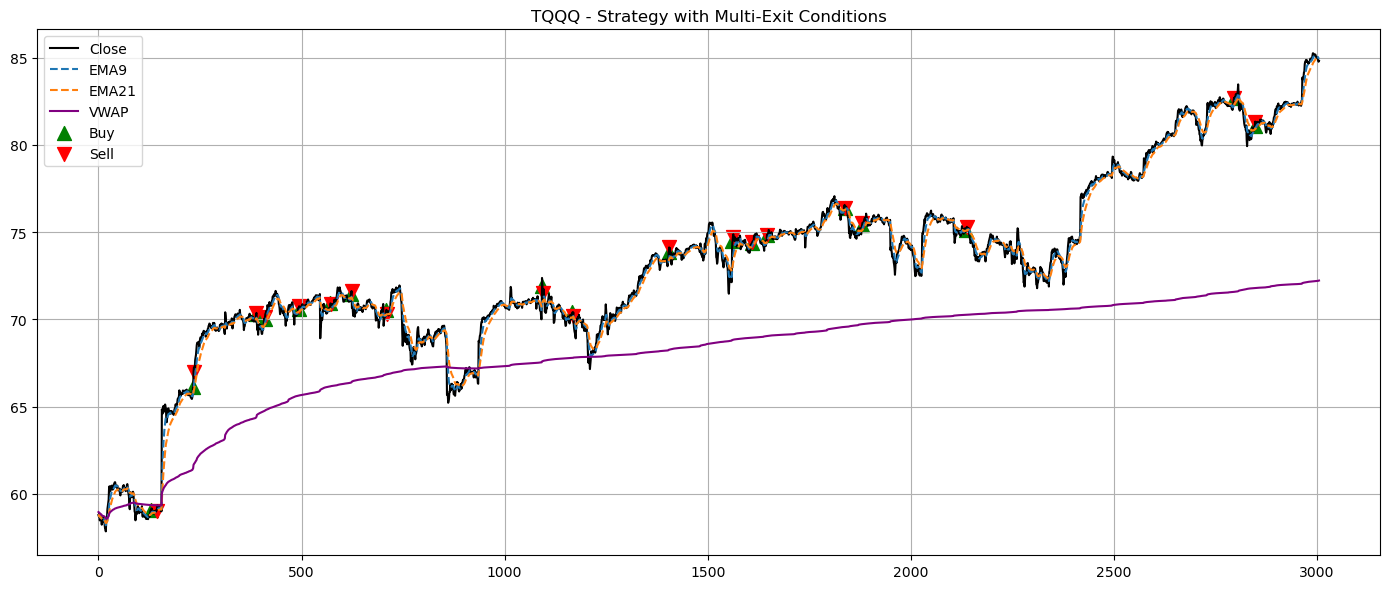

In [ ]:
# 买入逻辑
df["Signal"] = 0
df["Up1"] = df["Close"].diff(1).shift(1) > 0
df["Up2"] = df["Close"].diff(2).shift(1) > 0
df["VolUp"] =  df["Volume"].shift(1) > df["Volume"].shift(2) # df["Volume"].shift(0) > df["Volume"].shift(1) #

df.loc[
    (df["EMA9"] > df["EMA21"]) &
    (df["EMA9"].shift(1) <= df["EMA21"].shift(1)) &
    (df["RSI"].between(50, 70)) &
    (df["Up1"]) & (df["Up2"]) &
    (df["VolUp"]),
    "Signal"
] = 1

# 出场逻辑
df["Sell_Signal"] = 0
holding = False
buy_price = 0
buy_time = None
trades = []
for i in range(len(df)):
    row = df.iloc[i]
    time = row.name

    if row["Signal"] == 1:
        holding = True
        buy_price = row["Open"]
        buy_time = time
        buy_datetime = row['Datetime']
    elif holding:
        current_price = row["Close"]
        change_pct = (current_price - buy_price) / buy_price
        duration = (time - buy_time) / 60 if buy_time else 0
        vw_delta = (current_price - row["VWAP"]) / row["VWAP"]
        rsi_prev = df["RSI"].iloc[i - 1] if i > 0 else row["RSI"]

        # 止盈条件
        tp1 = change_pct >= 0.015
        tp2 = row["RSI"] > 70 and row["RSI"] < rsi_prev
        tp3 = vw_delta > 0.025
        if tp1 or tp2 or tp3:
            df.at[time, "Sell_Signal"] = -1
            sell_datetime = row['Datetime']
            holding = False
            if df.at[time, "Sell_Signal"] == -1 and buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": current_price,
                    "Return": change_pct
                })
                # 重置 buy_datetime 避免重复记录
                buy_datetime = None
            continue

        # 止损条件
        sl_conditions = [
            change_pct <= -0.005,
            row["EMA9"] <= row["EMA21"],
            row["RSI"] <= 50,
            row["Close"] < row["VWAP"],
            duration > 15
        ]
        if sum(sl_conditions) >= 2:
            df.at[time, "Sell_Signal"] = -1
            sell_datetime = row['Datetime']
            holding = False
            if df.at[time, "Sell_Signal"] == -1 and buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": current_price,
                    "Return": change_pct
                })
                # 重置 buy_datetime 避免重复记录
                buy_datetime = None

    

results = pd.DataFrame(trades)
if not results.empty:
    print("🔎 回测总结")
    print(results)
    print(f"✅ 总交易次数: {len(results)}")
    print(f"🏆 胜率: {round((results['Return'] > 0).sum() / len(results) * 100, 2)}%")
    print(f"📈 总收益: {round(results['Return'].sum() * 100, 2)}%")
    print(f"💰 每笔平均收益: {round(results['Return'].mean() * 100, 2)}%")


# 提取买卖点
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Sell_Signal"] == -1]

# 绘图展示
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"], label="Close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", label="Sell", s=100)
plt.title(f"{ticker} - Strategy with Multi-Exit Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3 bars delay backtest

🔎 回测总结
                    Buy_Time                 Sell_Time  Buy_Price  Sell_Price  \
0  2025-05-09 18:15:00+00:00 2025-05-09 19:10:00+00:00  59.014999   59.275002   
1  2025-05-13 13:55:00+00:00 2025-05-13 14:15:00+00:00  67.669899   68.661201   
2  2025-05-15 13:50:00+00:00 2025-05-15 14:10:00+00:00  69.125000   69.464500   
3  2025-05-15 15:35:00+00:00 2025-05-15 15:55:00+00:00  70.419800   70.699997   
4  2025-05-16 16:05:00+00:00 2025-05-16 16:25:00+00:00  70.724998   70.790001   
5  2025-05-19 16:05:00+00:00 2025-05-19 16:25:00+00:00  70.870003   71.129997   
6  2025-05-20 13:50:00+00:00 2025-05-20 14:10:00+00:00  70.199997   70.309998   
7  2025-05-21 14:35:00+00:00 2025-05-21 14:55:00+00:00  70.230003   70.989799   
8  2025-05-29 14:05:00+00:00 2025-05-29 14:25:00+00:00  71.050003   70.860001   
9  2025-05-30 13:45:00+00:00 2025-05-30 14:05:00+00:00  69.309998   69.765404   
10 2025-06-04 14:00:00+00:00 2025-06-04 14:20:00+00:00  73.790001   73.425003   
11 2025-06-06 14:05:0

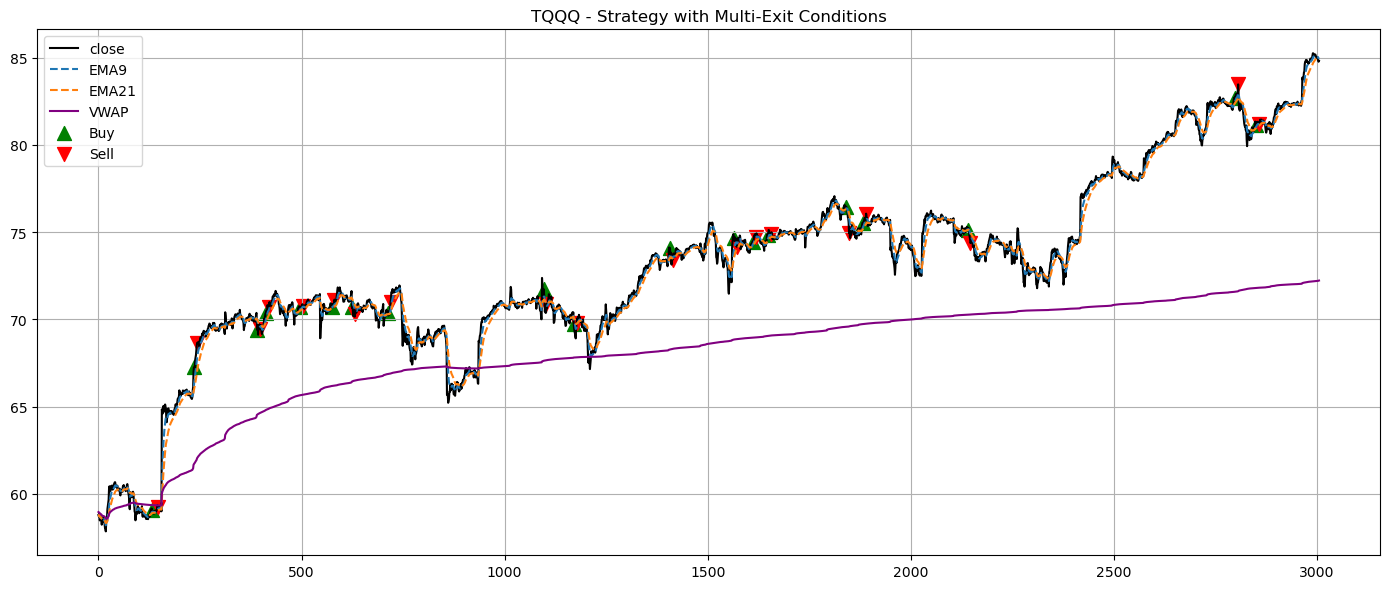

In [6]:
df["close"] = df["Close"]
df["open"] = df["Open"]
df['volume'] = df['Volume']
df['timestamp'] = df['Datetime']
# 买入逻辑
df["Signal"] = 0
df["Up1"] = df["close"].diff(1).shift(1) > 0
df["Up2"] = df["close"].diff(2).shift(1) > 0
df["VolUp"] =  df["volume"].shift(1) > df["volume"].shift(2)

signal_condition = (
    (df["EMA9"] > df["EMA21"]) &
    (df["EMA9"].shift(1) <= df["EMA21"].shift(1)) &
    (df["RSI"].between(50, 70)) &
    (df["Up1"]) & (df["Up2"]) & (df["VolUp"])
)

df.loc[signal_condition.shift(3, fill_value=False), "Signal"] = 1


df["Sell_Signal"] = 0
holding = False
buy_price = 0
buy_time = None
trades = []

for i in range(len(df)):
    if i < 3:
        continue  # 前3个bar跳过，因为无法滞后3位
    row = df.iloc[i]
    time = row.name

    # 延迟3根bar后的买入
    if df["Signal"].iloc[i - 3] == 1 and not holding:
        holding = True
        buy_price = row["open"]
        buy_time = time
        buy_datetime = row['timestamp']
        continue

    if holding:
        current_price = row["close"]
        change_pct = (current_price - buy_price) / buy_price
        duration = (time - buy_time) / 60 if buy_time else 0
        vw_delta = (current_price - row["VWAP"]) / row["VWAP"]
        rsi_prev = df["RSI"].iloc[i - 1] if i > 0 else row["RSI"]

        # 止盈条件
        tp1 = change_pct >= 0.015
        tp2 = row["RSI"] > 70 and row["RSI"] < rsi_prev
        tp3 = vw_delta > 0.025
        if tp1 or tp2 or tp3:
            # 延迟3根bar后的卖出
            if i + 3 < len(df):
                sell_index = df.index[i + 3]
                df.at[sell_index, "Sell_Signal"] = -1
                sell_datetime = df.at[sell_index, "timestamp"]
                sell_price = df.at[sell_index, "close"]
            else:
                df.at[time, "Sell_Signal"] = -1
                sell_datetime = row["timestamp"]
                sell_price = current_price

            holding = False
            if buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": sell_price,
                    "Return": (sell_price - buy_price) / buy_price
                })
                buy_datetime = None
            continue

        # 止损条件
        sl_conditions = [
            change_pct <= -0.005,
            row["EMA9"] <= row["EMA21"],
            row["RSI"] <= 50,
            row["close"] < row["VWAP"],
            duration > 15
        ]
        if sum(sl_conditions) >= 2:
            if i + 3 < len(df):
                sell_index = df.index[i + 3]
                df.at[sell_index, "Sell_Signal"] = -1
                sell_datetime = df.at[sell_index, "timestamp"]
                sell_price = df.at[sell_index, "close"]
            else:
                df.at[time, "Sell_Signal"] = -1
                sell_datetime = row["timestamp"]
                sell_price = current_price

            holding = False
            if buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": sell_price,
                    "Return": (sell_price - buy_price) / buy_price
                })
                buy_datetime = None


results = pd.DataFrame(trades)
if not results.empty:
    print("🔎 回测总结")
    print(results)
    print(f"✅ 总交易次数: {len(results)}")
    print(f"🏆 胜率: {round((results['Return'] > 0).sum() / len(results) * 100, 2)}%")
    print(f"📈 总收益: {round(results['Return'].sum() * 100, 2)}%")
    print(f"💰 每笔平均收益: {round(results['Return'].mean() * 100, 2)}%")


# 提取买卖点
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Sell_Signal"] == -1]

# 绘图展示
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell", s=100)
plt.title(f"{ticker} - Strategy with Multi-Exit Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()